<a href="https://colab.research.google.com/github/sayan0506/Classifying-Cityscape-data-using-Pretrained-Resnet-18-model-using-Discriminative-Learning/blob/main/Pretrained_Resnet_18_with_Discriminative_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Modules import**

In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

# this makes pyplot in interactive mode
plt.ion()

# **Loading the Cityscape imagepairs dataset from Kaggle**

Get multiple target image and label pairs

**Steps to download the dataset in collab**

1. Go to kaggle account, scroll to **API section**, and Click **Expire API Token** to remove previous tokens
2. Click on **Create New API Token**, it will download **kaggle.json** file on the machine
3. Go to google collab project notebook and run following commands in code shell


* Install Kaggle dependencies

In [34]:
# install the dependencies
!pip install kaggle

* import google.colab.files
* files.upload
* Choose the downloaded **kaggle.json**, and upload into collab

In [18]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sayanhazra05","key":"038235153b6e88572467ff31dbc34db3"}'}

* Run to create new directory named kaggle
>**!mkdir -p ~/.kaggle**
* Run this to copy kaggle.json into the directory
>**!cp kaggle.json ~/.kaggle/** 
* Run this to change the permission
>**!chmod 600 ~/.kaggle/kaggle.json** 

In [41]:
# create kaggle directory
!mkdir -p ~/.kaggle
# copy kaggle,json in the directory
!cp kaggle.json ~/.kaggle/

# change the permission
!chmod 600 ~/.kaggle/kaggle.json

* **Download the dataset**(follow general steps or run the command for now)
* Go to kaggle, search the competition, here **"Cityscapes Image Pairs"**, open it, navigate to marked section for selection


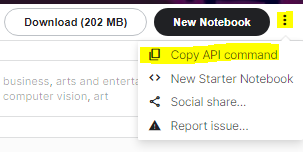

* **Click on copy API command**, for this Cityscapes dataset run the following
>**!kaggle datasets download -d dansbecker/cityscapes-image-pairs**
* Download the zip file

In [42]:
#download the dataset
!kaggle datasets download -d dansbecker/cityscapes-image-pairs

cityscapes-image-pairs.zip: Skipping, found more recently modified local copy (use --force to force download)


# Data Preperation

## Unzipping the dataset into train and test